# simple ml models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# path = 'F:\kaggle\digit recogniser'
path = ''
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

In [3]:
x = x/255

In [4]:
test_size = 0.2
x_training, x_test, y_training, y_test = train_test_split(x,y,test_size=test_size,shuffle = True)

## knn

In [7]:
%%time
knnclf = KNeighborsClassifier(n_neighbors=10)
knnclf.fit(x_training,y_training)
y_pred=knnclf.predict(x_test)

CPU times: user 7min 11s, sys: 92 ms, total: 7min 11s
Wall time: 7min 11s


In [9]:
print(accuracy_score(y_test,y_pred))

0.9667857142857142


# conv models

In [10]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
# !pip install livelossplot

In [16]:
from livelossplot.keras import PlotLossesCallback

In [17]:
train_log_file = "training_logs.csv"
model_sum_file = "model_summary.txt"
model_file = "model.h5"
train_plt_file = "training.png"
cv_plot_file = "validation.png"
submi_file = "result_convmodel.csv"

In [18]:
verb = 1
epoch_num = 100
batch_size = 512
class_num = 10
num_channels = 1
im_size = 28
im_width, im_height = im_size, im_size
test_size = 0.2

In [19]:

# Reshape data
x = x.values.reshape(-1, im_width, im_height, num_channels)
test = test.values.reshape(-1, im_width, im_height, num_channels)

# One-Hot encoding
y = to_categorical(y, num_classes=class_num)

# Prepare training/validation sets
x_training, x_test, y_training, y_test = train_test_split(x,y,test_size=test_size,shuffle = True)

#### conv model

In [20]:
conv_model = Sequential()

conv_model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(im_width, im_height, num_channels)))
conv_model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu'))
conv_model.add(MaxPool2D(pool_size=(2,2)))
conv_model.add(Dropout(0.5))
conv_model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
conv_model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
conv_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
conv_model.add(Dropout(0.5))

conv_model.add(Flatten())
conv_model.add(Dense(8192, activation='relu'))
conv_model.add(Dropout(0.5))

conv_model.add(Dense(2048, activation='relu'))
conv_model.add(Dropout(0.5))

conv_model.add(Dense(class_num, activation="softmax"))

conv_model.compile(optimizer=RMSprop(lr=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# conv_model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=5e-4), metrics = ["accuracy"])

# callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=2, mode='auto'),
#             ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

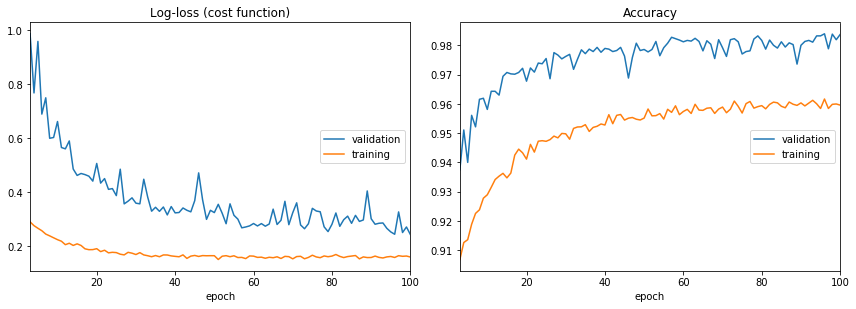

Log-loss (cost function):
validation (min:    0.242, max:    0.986, cur:    0.242)
training   (min:    0.150, max:    0.317, cur:    0.159)

Accuracy:
validation (min:    0.938, max:    0.984, cur:    0.984)
training   (min:    0.897, max:    0.962, cur:    0.960)
28000/28000 [==============================] - 63s 2ms/step


In [25]:
with open(model_sum_file,"w") as fh:
    conv_model.summary(print_fn=lambda line: fh.write(line + "\n"))

# Data augmentation create more images using this.
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)

# Training the model
history = conv_model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=batch_size),
                              epochs=epoch_num,
                              validation_data=(x_test, y_test),
                              verbose=verb,
                              steps_per_epoch=x_training.shape[0] // batch_size,
                              callbacks=[PlotLossesCallback(),
                                         CSVLogger(train_log_file,
                                                   append=False,
                                                   separator=";")])
conv_model.save_weights(model_file)

# Testing 
predictions = conv_model.predict_classes(test, verbose=1)
pd.DataFrame({"ImageId":list(range(1,len(predictions)+1)),
              "Label":predictions}).to_csv(submi_file,
                                           index=False,
                                           header=True)

# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(train_plt_file, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(cv_plot_file, bbox_inches='tight')
plt.close()

## different conv model

In [26]:
train_log_file1 = "training_logs1.csv"
model_sum_file1 = "model_summary1.txt"
model_file1 = "model1.h5"
train_plt_file1 = "training1.png"
cv_plot_file1 = "validation1.png"
submi_file1 = "result_convmodel1.csv"

In [34]:
conv_model1 = Sequential()

conv_model1.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(im_width, im_height, num_channels)))
conv_model1.add(BatchNormalization())

# conv_model1.add(Conv2D(filters=32,
#                  kernel_size=(5,5),
#                  padding='Same', 
#                  activation='relu'))
# conv_model1.add(BatchNormalization())

conv_model1.add(MaxPool2D(pool_size=(2,2)))
conv_model1.add(Dropout(0.5))
conv_model1.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
conv_model1.add(BatchNormalization())

# conv_model1.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
#                  activation='relu'))
# conv_model1.add(BatchNormalization())

conv_model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
conv_model1.add(Dropout(0.5))

conv_model1.add(Flatten())
conv_model1.add(Dense(8192, activation='relu'))
conv_model1.add(Dropout(0.5))

conv_model1.add(Dense(2048, activation='relu'))
conv_model1.add(Dropout(0.5))

conv_model1.add(Dense(class_num, activation="softmax"))

conv_model1.compile(optimizer=RMSprop(lr=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

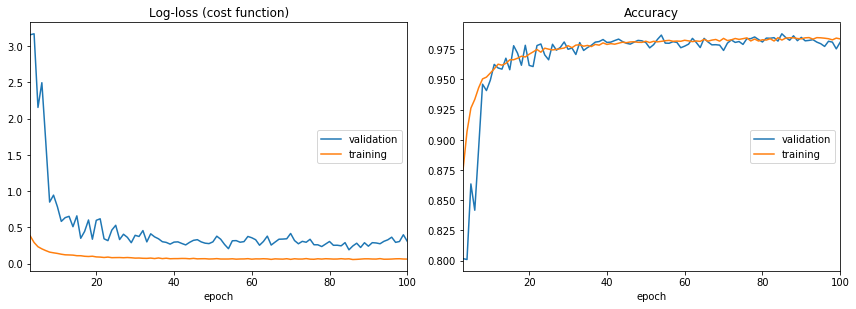

Log-loss (cost function):
validation (min:    0.190, max:    6.216, cur:    0.307)
training   (min:    0.056, max:    1.084, cur:    0.062)

Accuracy:
validation (min:    0.610, max:    0.988, cur:    0.981)
training   (min:    0.638, max:    0.985, cur:    0.984)
28000/28000 [==============================] - 50s 2ms/step


In [36]:
with open(model_sum_file1,"w") as fh:
    conv_model1.summary(print_fn=lambda line: fh.write(line + "\n"))


# Training
history = conv_model1.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=batch_size),
                              epochs=epoch_num,
                              validation_data=(x_test, y_test),
                              verbose=verb,
                              steps_per_epoch=x_training.shape[0] // batch_size,
                              callbacks=[PlotLossesCallback(),
                                         CSVLogger(train_log_file1,
                                                   append=False,
                                                   separator=";")])
conv_model1.save_weights(model_file1)

# Testing
predictions = conv_model1.predict_classes(test, verbose=1)
pd.DataFrame({"ImageId":list(range(1,len(predictions)+1)),
              "Label":predictions}).to_csv(submi_file1,
                                           index=False,
                                           header=True)

# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(train_plt_file1, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(cv_plot_file1, bbox_inches='tight')
plt.close()
